## Exploration 6. 수식 없이도 이해할 수 있는 ChatGPT와 Stable Diffusion

# Project 'ControlNet으로 조건을 준 이미지 생성'

- Stable Diffusion으로 이미지를 생성하는것에서 더 나아가 ControlNet을 사용해서 이미지에 조건을 주고 이미지를 다양하게 변형

---

# ControlNet

- Diffusion 모델에 추가 조건을 넣어서 출력되는 이미지를 제어할수 있게 만든 모델
    - 원하는 자세, 구도 등으로 이미지를 생성
- 훈련 데이터가 작아도 학습이 잘 되고 빠름
- 논문 '[Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)'
- 인체 자세 감지(human pose), 낙서 지도(scribble map), Semantic segmentation등 다양한 preprocessor를 Stable Diffusion 모델에 도입할수 있음

<img src='./img/controlnet.png'>

[Code REF] [Hugging Face](https://huggingface.co/docs/diffusers/v0.17.1/en/api/pipelines/stable_diffusion/overview)

In [1]:
# install Stable Diffusion
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
# clear gpu memory
# torch.cuda.empty_cache()

- 위 코드는 소용이 없었다. 메모리 에러가 뜨면 kernel restart후에 해당 부분부터 재실행한다

# 윤곽선 검출
- 유명한 윤곽선검출 알고리즘 'Canny' 알고리즘 사용

In [3]:
# import library
import torch
# pipeline, controlnet, scheduler(윤곽선추출한 이미지에 프롬프트로 새로운 이미지 생성)
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image 
import cv2
from PIL import Image 
import numpy as np

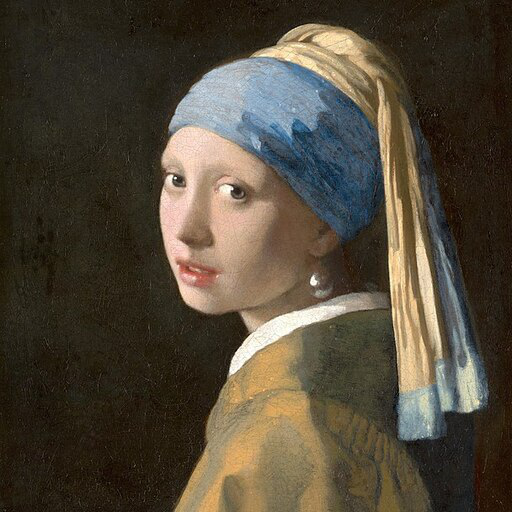

In [4]:
# load image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

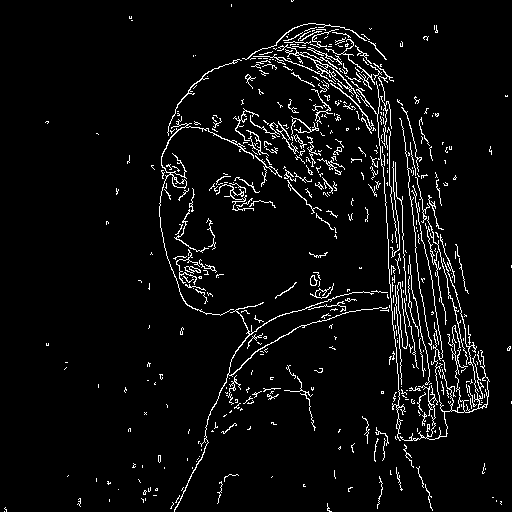

In [5]:
# convert the image to a NumPy array 
image = np.array(image)

# set threshold
''' "threshold" refers to the intensity values used to determine 
    which edges should be considered strong, weak, or non-edges.
'''
low_threshold = 100
high_threshold = 200

# detect outline 
image = cv2.Canny(image, low_threshold, high_threshold)

# add 3rd dim : 2d grayscale image to 3d image with a single channel
image = image[:, :, None] 

# replicate the single channel image into 3 channels
image = np.concatenate([image, image, image], axis=2)

# convert a numpy arry to PIL image
canny_image = Image.fromarray(image)  

canny_image

In [9]:
# make pipeline
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# generate new image by applying prompts to outlined image
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# set seed
generator = torch.manual_seed(33)  

# generate the image
canny_image = canny_pipe(
    prompt="red queen of Wonderland on the beach", 
    num_inference_steps=10, 
    generator=generator, 
    image=canny_image
).images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# canny_pipe = canny_pipe.to("cpu")

# # set seed
# generator = torch.manual_seed(0)  

# # generate the image
# canny_image = canny_pipe(
#     prompt="red queen of Wonderland on the beach", 
#     num_inference_steps=20, 
#     generator=generator, 
#     image=canny_image
# ).images[0]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'

- CUDA memory error가 나는데, cpu로는 사용이 안된다고하니 문제다!

In [10]:
import os
# from PIL import Image

# save the image
def save_image(image, filename="new_image.png"):
    """
    Save the provided image to the specified file path.

    Parameters:
    - image: The image to be saved.
    - filename: The desired filename for the saved image (default is "canny_image.png").
    """
    # Get the current working directory
    current_directory = os.getcwd()

    # Make the file path
    file_path = os.path.join(current_directory, filename)

    # Save the image
    image.save(file_path)
    
    # Display the image
    image.show()

    print(f"Image saved successfully at: {file_path}")

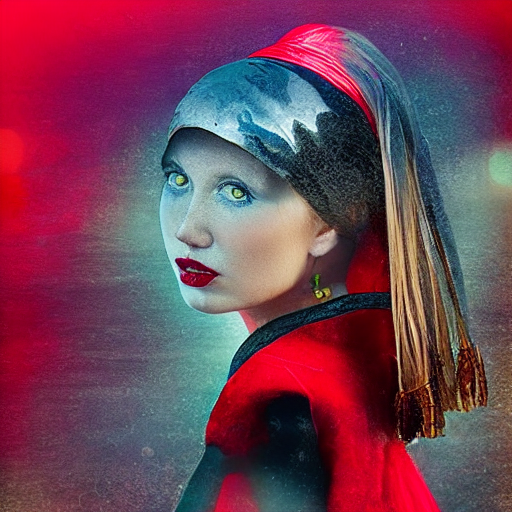

Image saved successfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/canny_red_queen.png


In [11]:
save_image(canny_image, 'canny_red_queen.png')

### hyperparameter 조정
- `negative_propmt` : 원하지 않는 요소를 정하고 해당 키워드는 제외
- `controlnet_conditioning_scale`: ContorlNet으로 조건을 어느 정도 주느냐를 조절
    - Default = 1, 실수값으로 설정
- `num_inference_steps`: 추론 횟수
    - 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸림
    - default = 50
- `guidance_scale`: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정
    - 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어짐
    - default = 7.5

In [14]:
def canny_image_with_hyperparameters(canny_image, canny_pipe, controlnet_conditioning_scale=1.0,
                                        num_inference_steps=15, guidance_scale=7.5):
    """
    Generate an image with specified hyperparameters.

    Parameters:
    - canny_pipe: The image generation pipeline.
    - controlnet_conditioning_scale: ControlNet conditioning scale (default is 1.0).
    - num_inference_steps: Number of inference steps for image generation (default is 50).
    - guidance_scale: Guidance scale for image generation (default is 7.5).

    Returns:
    - The generated image.
    """
    # Set up scheduler and move the pipeline to CUDA
    canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
    canny_pipe = canny_pipe.to("cuda")

    # Set seed for reproducibility
    generator = torch.manual_seed(33)

    # Get the prompt from user input
    prompt = input("Enter the prompt for image generation: ")

    # Generate the image with specified hyperparameters
    canny_image = canny_pipe(prompt=prompt,
                             controlnet_conditioning_scale=controlnet_conditioning_scale,
                             num_inference_steps=num_inference_steps,
                             guidance_scale=guidance_scale,
                             generator=generator,
                             image=canny_image).images[0]

    return canny_image

In [7]:
# canny_image = canny_image_with_hyperparameters(canny_pipe,
#                                                controlnet_conditioning_scale=1.5,
#                                                num_inference_steps=15,
#                                                guidance_scale=6)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [15]:
# make outlined canny image
# convert the image to a NumPy array 
image = np.array(image)

# set threshold
''' "threshold" refers to the intensity values used to determine 
    which edges should be considered strong, weak, or non-edges.
'''
low_threshold = 100
high_threshold = 200

# detect outline 
image = cv2.Canny(image, low_threshold, high_threshold)

# add 3rd dim : 2d grayscale image to 3d image with a single channel
image = image[:, :, None] 

# replicate the single channel image into 3 channels
image = np.concatenate([image, image, image], axis=2)

# convert a numpy arry to PIL image
canny_outline_image = Image.fromarray(image)  

In [16]:
# generate canny image using hyperparameters
canny_image = canny_image_with_hyperparameters(canny_outline_image, canny_pipe,
                                               controlnet_conditioning_scale=1.5,
                                               num_inference_steps=15,
                                               guidance_scale=6)

Enter the prompt for image generation: a warm and cozy atmosphere with an Asian girl with black hair on the beach


  0%|          | 0/15 [00:00<?, ?it/s]

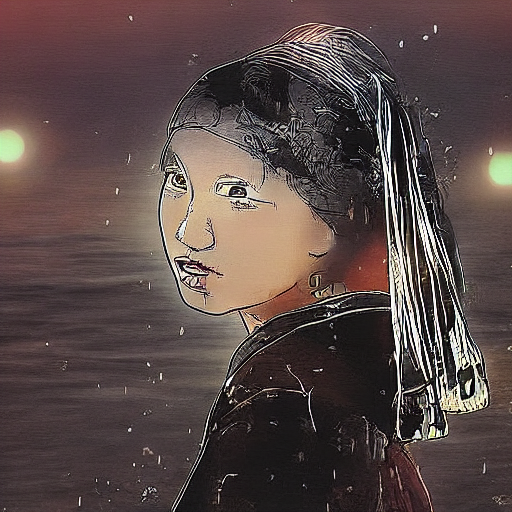

Image saved successfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/new_image.png


In [17]:
save_image(canny_image)

## 인체 자세 감지
- `Openpose` : 인체 자세 감지(Human pose)를 할수 있는 전처리기
    - 자세를 감지해서 새로운 이미지로 생성

In [18]:
# install controlnet-aux : a supplementary model for controlnet to detect human pose
!pip install controlnet-aux==0.0.1

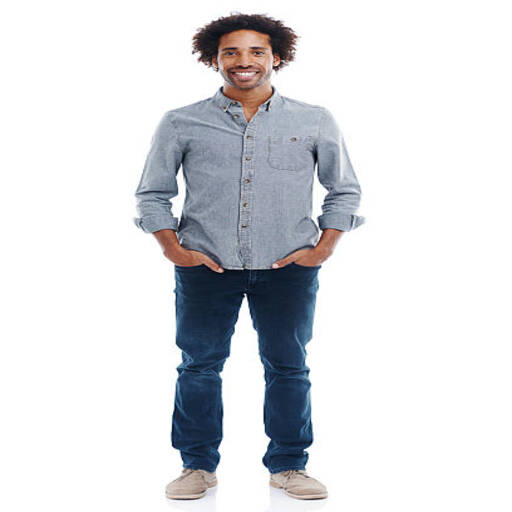

In [19]:
# load image
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


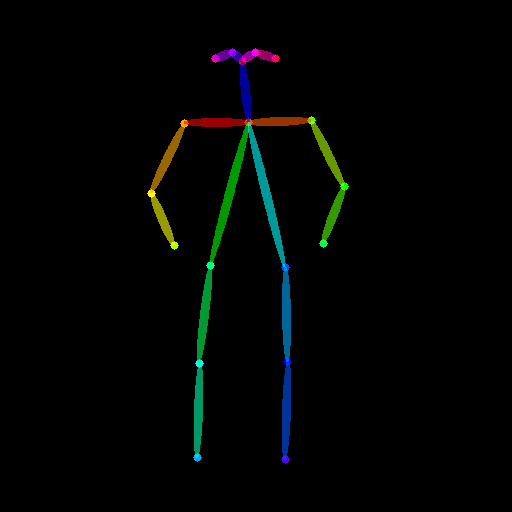

In [20]:
from controlnet_aux import OpenposeDetector

# Load pretrained ControlNet that detects human pose
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# Human pose detection
openpose_image = openpose(openpose_image)
openpose_image

In [11]:
# make pipeline
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

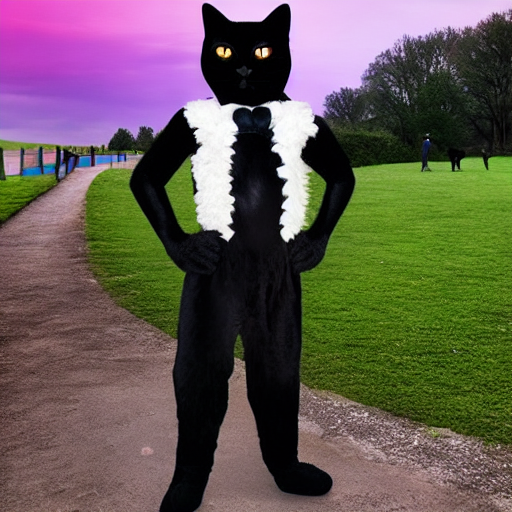

In [23]:
from diffusers import UniPCMultistepScheduler

# Set up scheduler and move the pipeline to CUDA
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Set a seed for reproducibility
generator = torch.manual_seed(33)

# Create prompts
prompt = 'a black cat dancing in the parc'
negative_prompt = 'a bird sleepin on the sofa'

# Generate images
openpose_image1 = openpose_pipe(
    prompt=prompt, negative_prompt=negative_prompt, 
    num_inference_steps=25, generator=generator, image=openpose_image).images[0]

# Display the generated image
openpose_image1.show()

# 윤곽선 검출 + 인체 자세 감지
- 'controlnets' list를 만들어서 2개의 전처리기를 동시에 사용
    - 리스트를 파이프라인에 전달

## Canny 알고리즘을 사용한 윤곽선 검출
- Canny 알고리즘으로 윤곽선을 검출한 이미지위에 인체 자세 검출 전처리기를 올린다
    - 인체 자세를 넣어줄 부분을 이미지 내에서 지워야한다는 점 유의!

In [1]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np

# Load image
image = load_image(
    "https://screenmusings.org/movie/blu-ray/Emma/images/Emma-0532.jpg"
)
image.size

(1920, 1080)

In [2]:
# resize for dimension-related error
'''The size of tensor a (96) must match the size of tensor b (240) at non-singleton dimension 3'''
# resize resolution 
desired_size = (768, 512)

# image resizing
image = image.resize(desired_size, Image.ANTIALIAS)
image.size

(768, 512)

In [3]:
# convert the image to a NumPy array 
image = np.array(image)

# set threshold
''' "threshold" refers to the intensity values used to determine 
    which edges should be considered strong, weak, or non-edges.
'''
low_threshold = 100
high_threshold = 200

# Erase the center where to put the human pose
zero_start = image.shape[1] // 4
zero_end = zero_start + image.shape[1] // 2
image[:, zero_start:zero_end] = 0

# detect outline 
image = cv2.Canny(image, low_threshold, high_threshold)

# add 3rd dim : 2d grayscale image to 3d image with a single channel
image = image[:, :, None] 

# replicate the single channel image into 3 channels
image = np.concatenate([image, image, image], axis=2)

# convert a numpy arry to PIL image
canny_outline_image = Image.fromarray(image)  

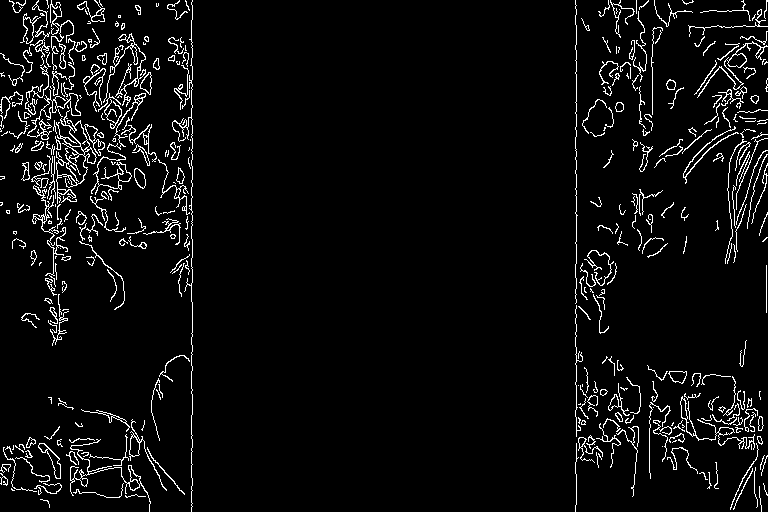

In [4]:
canny_outline_image

## Openpose 를 사용한 인체자세검출

In [5]:
# Human pose detection
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Load image
openpose_image = load_image(
    "https://www.liveabout.com/thmb/-bWR5HYmGm6-bodvA2v6aJwh6uM=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-1091825900-8ba9a3d0e2c440c382ed83d11501a4b4.jpg"
)

# Human pose dectection using OpenposeDetector
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


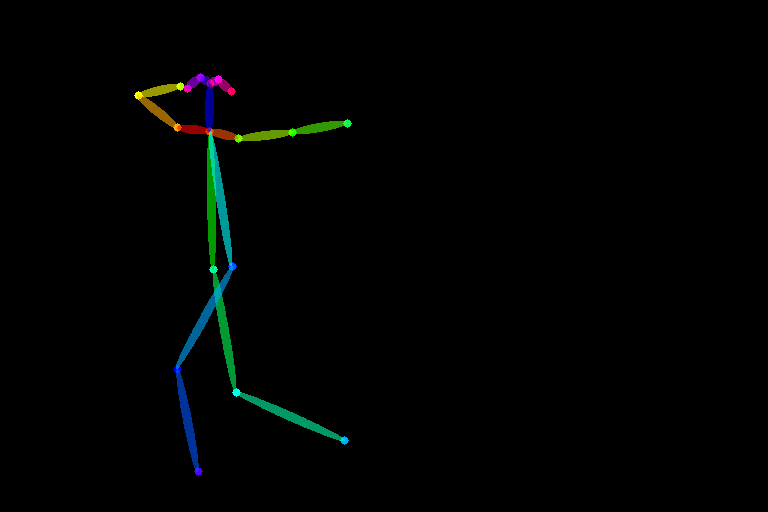

In [6]:
openpose_image

In [7]:
openpose_image.size

(768, 512)

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# make canny pipeline
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

# make openpose pipeline
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

# list variable : Edge Detection, Openpose
controlnets = [canny_controlnet, openpose_controlnet]


# Pass the list to the pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# set prompt
prompt =  'snow white of diseny dancing with animals in the forest'
negative_prompt =  'crying people in the dark wasteland'

# set seed
generator = torch.Generator(device='cuda').manual_seed(33)

images = [openpose_image, canny_outline_image]

# generate the image
canny_openpose_image = pipe(
    prompt=prompt, negative_prompt=negative_prompt,
    num_inference_steps=15, generator=generator, image=images).images[0]

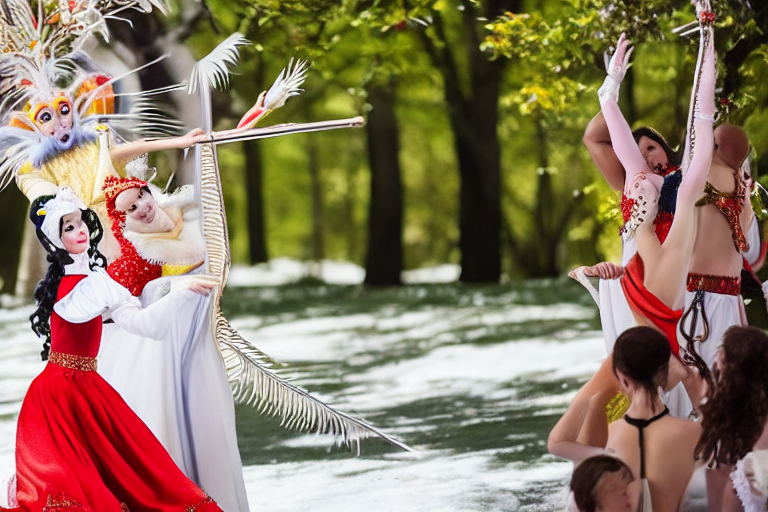

In [9]:
import os

# get the current working directory
current_directory = os.getcwd()

# make file path
file_path = os.path.join(current_directory, "/multi_controlnet_output.png")

# save the image
canny_openpose_image.save(file_path)

# display the image
canny_openpose_image.show()

# ===== SUMMARY =====
정말 어려웠다:) 무슨 내용인지 이해하지 못하고 일단 따라하는 방식이었는데, 마지막에 윤곽선 검출과 위치정보값으로 이미지를 생서할때 가운데 부분이 비워져서 나온건 당연한건지, 다시 천천히 공부가 필요하다

# ===== KPT =====
**[KEEP]**
- 새로운 코드와 이론을 보는걸 두려워하지않았다:)

**[PROBLEM]**
- 윤곽선 검출한 정보값으로 어떻게 이미지가 생성되는지 이해가 되지않는다
- 포즈 정보를 이용해서 이미지가 정말 생성된건 확인했는데, 마지막에 윤곽선 검출한 정보값과 함께 이미지를 생성하는 부분에서는 어떤 방식인건지 이해하지 못했다.

**[TRY]**
- 문제의 부분을 다시 추가 공부를 해본다